DeepDream is an artistic image-modification technique that uses the representations
learned by convolutional neural networks

The DeepDream algorithm is almost identical to the convnet filter-visualization technique consisting of running a convnet in reverse: doing gradient ascent on the input to the convnet in order to maximize the activation of a
specific filter in an upper layer of the convnet.

 DeepDream uses this same idea, with a
few simple differences:


 With DeepDream, you try to maximize the activation of entire layers rather
than that of a specific filter, thus mixing together visualizations of large numbers of features at once.


 You start not from blank, slightly noisy input, but rather from an existing
image—thus the resulting effects latch on to preexisting visual patterns, distorting elements of the image in a somewhat artistic fashion.


 The input images are processed at different scales (called octaves), which
improves the quality of the visualizations.

440742/440742 [==============================] - 0s 1us/step


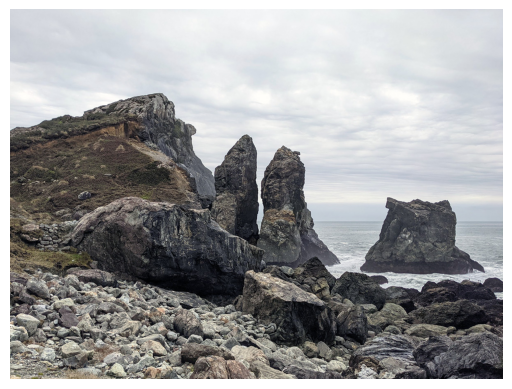

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
base_image_path = keras.utils.get_file(
 "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

Next, we need a pretrained convnet. In Keras, many such convnets are available:
VGG16, VGG19, Xception, ResNet50, and so on, all available with weights pretrained
on ImageNet. You can implement DeepDream with any of them, but your base model
of choice will naturally affect your visualizations, because different architectures result
in different learned features. The convnet used in the original DeepDream release
was an Inception model, and in practice, Inception is known to produce nice-looking
DeepDreams, so we’ll use the Inception V3 model that comes with Keras

In [ ]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87910968/87910968 [==============================] - 3s 0us/step


We’ll use our pretrained convnet to create a feature exactor model that returns the
activations of the various intermediate layers, listed in the following code. For each
layer, we pick a scalar score that weights the contribution of the layer to the loss we will
seek to maximize during the gradient ascent process. If you want a complete list of
layer names that you can use to pick new layers to play with, just use model.summary().

In [ ]:
# Layers for which we try to maximize activation, as well as their weight in the total loss. You can tweak these setting to obtain new visual effects.
layer_settings = {
 "mixed4": 1.0,
 "mixed5": 1.5,
 "mixed6": 2.0,
 "mixed7": 2.5,
}

# Symbolic outputs of each layer
outputs_dict = dict(
 [
 (layer.name, layer.output)
 for layer in [model.get_layer(name)
 for name in layer_settings.keys()]
 ]
)

# Model that returns the activation values for every target layer (as a dict)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

Next, we’ll compute the loss: the quantity we’ll seek to maximize during the gradientascent process at each processing scale. For filter visualization, we tried to
maximize the value of a specific filter in a specific layer.

Here, we’ll simultaneously
maximize the activation of all filters in a number of layers. Specifically, we’ll maximize
a weighted mean of the L2 norm of the activations of a set of high-level layers.

The
exact set of layers we choose (as well as their contribution to the final loss) has a major
influence on the visuals we’ll be able to produce, so we want to make these parameters
easily configurable.

 Lower layers result in geometric patterns, whereas higher layers
result in visuals in which you can recognize some classes from ImageNet (for example,
birds or dogs). We’ll start from a somewhat arbitrary configuration involving four layers—but you’ll definitely want to explore many different configurations later.

In [ ]:
# The DeepDream loss

def compute_loss(input_image):
 features = feature_extractor(input_image) # Extract activations.
 loss = tf.zeros(shape=()) # Initialize the loss to 0.
 for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]
    loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :])) # We avoid border artifacts by only involving non-border pixels in the loss. # L2 norm
 return loss

Now let’s set up the gradient ascent process that we will run at each octave. The
DeepDream algorithm is simply a multiscale form of filter visualization.

In [ ]:
import tensorflow as tf

@tf.function # We make the training step fast by compiling it as a tf.function.
def gradient_ascent_step(image, learning_rate):
 # Compute gradients of DeepDream loss with respect to the current image.
 with tf.GradientTape() as tape:
    tape.watch(image)
    loss = compute_loss(image)
 grads = tape.gradient(loss, image)
 grads = tf.math.l2_normalize(grads) # Normalize gradients
 image += learning_rate * grads
 return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None): # This runs gradient ascent for a given image scale (octave).
 for i in range(iterations): # Repeatedly update the image in a way that increases the DeepDream loss.
    loss, image = gradient_ascent_step(image, learning_rate)
    if max_loss is not None and loss > max_loss: # Break out if the loss crosses a certain threshold (over-optimizing would create unwanted image artifacts).
      break
 print(f"... Loss value at step {i}: {loss:.2f}")
 return image

Finally, the outer loop of the DeepDream algorithm.

First, we’ll define a list of scales
(also called octaves) at which to process the images. We’ll process our image over
three different such “octaves.” For each successive octave, from the smallest to the
largest, we’ll run 20 gradient ascent steps via gradient_ascent_loop() to maximize
the loss we previously defined.


Between each octave, we’ll upscale the image by 40%
(1.4x): we’ll start by processing a small image and then increasingly scale it up (see


 We define the parameters of this process in the following code. Tweaking these
parameters will allow you to achieve new effects!

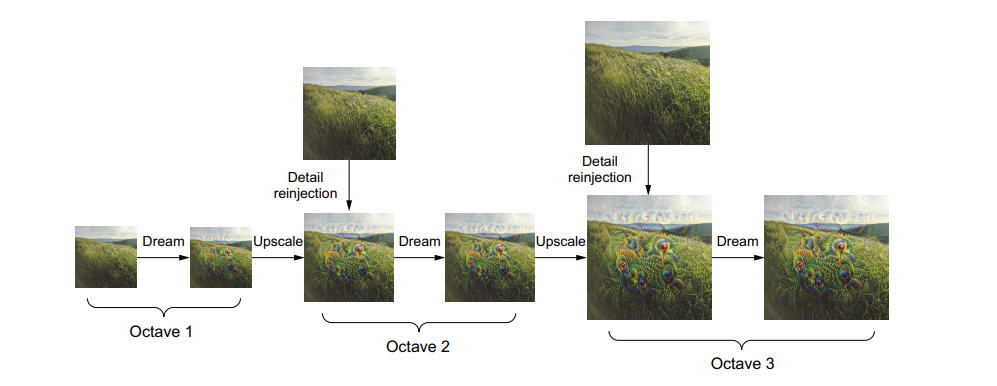

In [ ]:
step = 20. # Gradient ascent step size
num_octave = 3 # Number of scales at which to run gradient ascent
octave_scale = 1.4 # Size ratio between successive scales
iterations = 30 # Number of gradient ascent steps per scale
max_loss = 15. # We’ll stop the gradient ascent process for a scale if the loss gets higher than this

We’re also going to need a couple of utility functions to load and save images.

In [ ]:
import numpy as np

def preprocess_image(image_path): # Util function to open, resize, and format pictures into appropriate arrays
 img = keras.utils.load_img(image_path)
 img = keras.utils.img_to_array(img)
 img = np.expand_dims(img, axis=0)
 img = keras.applications.inception_v3.preprocess_input(img)
 return img

def deprocess_image(img): # Util function to convert a NumPy array into a valid image
 img = img.reshape((img.shape[1], img.shape[2], 3))
 # Undo inception v3 preprocessing.
 img /= 2.0
 img += 0.5
 img *= 255.

 # Convert to uint8 and clip to the valid range [0, 255].
 img = np.clip(img, 0, 255).astype("uint8")
 return img

This is the outer loop. To avoid losing a lot of image detail after each successive scaleup (resulting in increasingly blurry or pixelated images), we can use a simple trick:

after each scale-up, we’ll re-inject the lost details back into the image, which is possible
because we know what the original image should look like at the larger scale. Given a
small image size S and a larger image size L, we can compute the difference between
the original image resized to size L and the original resized to size S—this difference
quantifies the details lost when going from S to L.

In [ ]:
# Running gradient ascent over multiple successive "octaves"

original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]
successive_shapes = [original_shape]

# Compute the target shape of the image at different octaves.
for i in range(1, num_octave):
 shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
 successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]


shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img) # Make a copy of the image (we need to keep the original around).

for i, shape in enumerate(successive_shapes): # Iterate over the different octaves
 print(f"Processing octave {i} with shape {shape}")
 img = tf.image.resize(img, shape) # Scale up the dream image.
 img = gradient_ascent_loop(img, iterations=iterations, learning_rate=step, max_loss=max_loss) # Run gradient ascent, altering the dream.
 upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape) # Scale up the smaller version of the original image: it will be pixellated.
 same_size_original = tf.image.resize(original_img, shape) # Compute the high-quality version of the original image at this size.
 lost_detail = same_size_original - upscaled_shrunk_original_img # The difference between the two is the detail that was lost when scaling up.
 img += lost_detail # Re-inject lost detail into the dream.
 shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (459, 612)
... Loss value at step 29: 10.27
Processing octave 1 with shape (642, 857)
... Loss value at step 29: 12.61
Processing octave 2 with shape (900, 1200)
... Loss value at step 29: 12.56


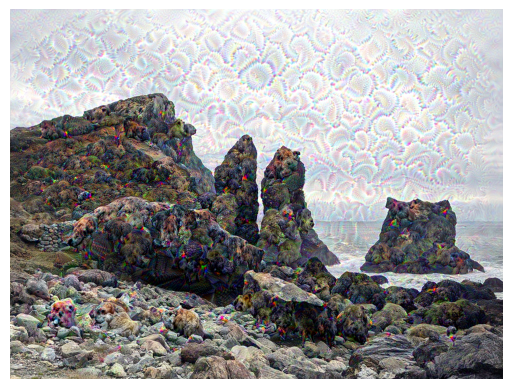

In [ ]:
plt.axis("off")
plt.imshow(keras.utils.load_img("/content/dream.png"))

**NOTE:**

Because the original Inception V3 network was trained to recognize concepts in images of size 299 × 299, and given that the process involves scaling the
images down by a reasonable factor, the DeepDream implementation produces
much better results on images that are somewhere between 300 × 300 and 400 ×
400. Regardless, you can run the same code on images of any size and any ratio.

I strongly suggest that you explore what you can do by adjusting which layers you
use in your loss.

 Layers that are lower in the network contain more-local, less-abstract
representations and lead to dream patterns that look more geometric.

 Layers that are
higher up lead to more-recognizable visual patterns based on the most common objects found in ImageNet, such as dog eyes, bird feathers, and so on.

You can use random generation of the parameters in the layer_settings dictionary to quickly explore many
different layer combinations.

Wrapping up


 DeepDream consists of running a convnet in reverse to generate inputs based
on the representations learned by the network.


 The results produced are fun and somewhat similar to the visual artifacts
induced in humans by the disruption of the visual cortex via psychedelics.


 Note that the process isn’t specific to image models or even to convnets. It can
be done for speech, music, and more.

[Explanation of what is Deep Dream and above things](https://chat.openai.com/share/44f2d102-8b49-4f3c-8fe7-2b7f2a690e44)